---
skip_showdoc: true
---

# 🔥 Dataloader: Numpy to Mojo Matrix 

In [ ]:
from PythonInterface import Python

let pathlib = Python.import_module("pathlib") # Python standard library
let gzip = Python.import_module("gzip") # Python standard library
let pickle = Python.import_module("pickle") # Python standard library
let np = Python.import_module("numpy")

We will work with the MNIST dataset. The first milestone is to be able to read and load the data as a Matrix struct.

## Get the data

In [ ]:
path_gz = pathlib.Path('./lost+found/data/mnist.pkl.gz')
f = gzip.open(path_gz, 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
data = u.load()

data_train = data[0]
data_valid = data[1]

x_train = data_train[0]
y_train = data_train[1]
y_train = np.expand_dims(y_train, 1)

x_valid = data_valid[0]
y_valid = data_valid[1]
y_valid = np.expand_dims(y_valid, 1)
f.close()

## Look at the data

In [ ]:
print(x_train[0].shape)

(784,)


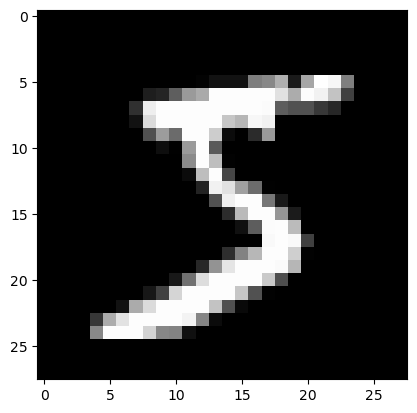

In [ ]:
let mpl = Python.import_module("matplotlib")
img = np.reshape(x_train[0], (28,28))
mpl.pyplot.imshow(img, 'gray')
mpl.pyplot.show()

So now we have the data as numpy arrays. The next step is to see how we can get it into a Matrix.

## Matrix

The implementation of the Matrix struct below is taken from the Mojo documentation.

In [ ]:
from DType import DType
from Memory import memset_zero
from Object import object, Attr
from Pointer import DTypePointer, Pointer
from Random import rand
from Range import range
from TargetInfo import dtype_sizeof

struct Matrix[type: DType]:
    var data: DTypePointer[type]
    var rows: Int
    var cols: Int

    fn __init__(inout self, rows: Int, cols: Int):
        self.data = DTypePointer[type].alloc(rows * cols)
        rand(self.data, rows*cols)
        self.rows = rows
        self.cols = cols

    fn __copyinit__(inout self, other: Self):
        self.data = other.data
        self.rows = other.rows
        self.cols = other.cols

    fn __del__(owned self):
        self.data.free()

    fn zero(inout self):
        memset_zero(self.data, self.rows * self.cols)

    @always_inline
    fn __getitem__(self, y: Int, x: Int) -> SIMD[type, 1]:
        return self.load[1](y, x)

    @always_inline
    fn load[nelts:Int](self, y: Int, x: Int) -> SIMD[type, nelts]:
        return self.data.simd_load[nelts](y * self.cols + x)

    @always_inline
    fn __setitem__(self, y: Int, x: Int, val: SIMD[type, 1]):
        return self.store[1](y, x, val)

    @always_inline
    fn store[nelts:Int](self, y: Int, x: Int, val: SIMD[type, nelts]):
        self.data.simd_store[nelts](y * self.cols + x, val)

## A Mojo _dataloader_

In [ ]:
let bs: Int = 5 # batch-size
let ni: Int = 28*28

let xb: Matrix[DType.float32] = Matrix[DType.float32](bs,ni)
let yb: Matrix[DType.float32] = Matrix[DType.float32](bs,1)
xb.zero()
yb.zero()

In [ ]:
fn matrix_dataloader[type: DType]( a:PythonObject, o: Matrix[type], bs: Int) raises -> Matrix[type]:
    for i in range(bs):
        for j in range(o.cols):
            o[i,j] = a[i][j].to_float64().cast[type]()
    return o

In [ ]:
xb = matrix_dataloader(x_train, xb, bs)
yb = matrix_dataloader(y_train, yb, bs)

In [ ]:
print(xb.rows)
print(xb.cols)
print(yb.rows)
print(yb.cols)

5
784
5
1
